In [1]:
from ipynb.fs.full.Funciones_basicas import *
from ipynb.fs.full.Algoritmos import *
from ipynb.fs.full.Visualizaciones import *

# Simulaciones

# Ejemplos de uso
## Instanciar el grafo

In [2]:
path = 'data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep = ';')
geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
path_pesos = 'data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    S.add(origin)
    S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    G.add_edge(id_[origin], id_[dest])
    
N = l

W = [0 for u in range(N)]
V = [0 for u in range(N)]

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

## Algunos ejemplos de uso de códigos para obtener y visualizar resultados

Máximo de nodos por ideal: 460


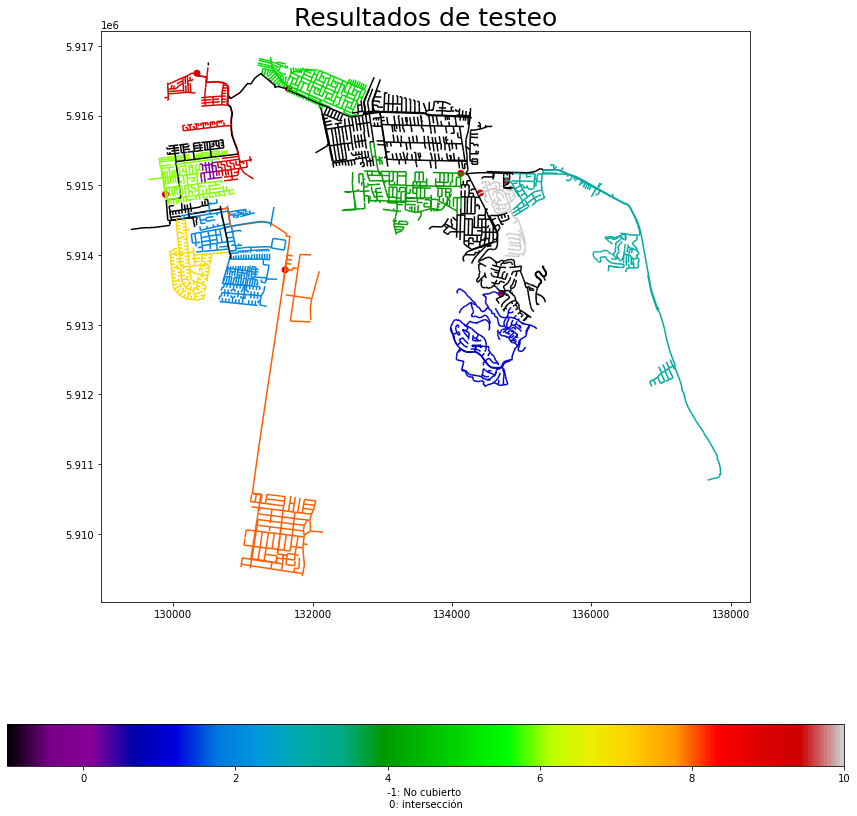

In [3]:
V = [0 for u in range(N)]
max_nodes = N // 10
print(f'Máximo de nodos por ideal: {max_nodes}')
ans = greedyApp(G, W, V, 10, max_nodes, 200000)
plot_solution(ans, G, N, geometry, _id)

In [ ]:
# K = 13
# nodes_limit = 800
# weight_limit = 10e8
# G_ = G.copy()
# nodos_inicial = len(G_.nodes())
# salida = id_[1001544]

# V = [0] * N

# low = 0; high = N
# while low != high:
#     mid = (low + high) // 2
#     P, sP = greedyAppWeightReduceDynamic(G, V, N, K, mid, 100000000)
#     if N - sP < mid:
#         high = mid
#     else:
#         low = mid + 1

# low -= 1


# sample, sP = greedyAppWeightReduceDynamic(G, V, N, K, low, 100000000)

# print(low, N - sP)
# print(len(sample))  ## if less than 8 entire graph gets covered with less samples

# plot_sample_no_intersections(G, V, N, sample, geometry.copy())

In [ ]:
V = [0] * N
ans, sol_dict, sizes, sol_ideals = greedyAppWeightReduceDynamic_partition(G, V, N, 13, 300, 10e7)
plot_from_ideals(sol_ideals, G, N, geometry, _id)
plot_sizes(list(sizes.values()))

## Djikstra para limpiar grafo

La función distance recibe una fila de un GeoPandas DataFrame. Esta construida la función para que el objeto geométrico a evaluar sea un Linestring. A partir de esto busca retornar la distancia entre estos dos puntos. En caso de que no se pueda, asignará un valor arbitratio previamente definido. En nuestro caso se usó la media del resto de las aristas para determinar este valor. Este procedimiento se describe en la celda siguiente.

In [ ]:
def distance(row, mean_weights):
  try:
    x_1 = row['geometry'].coords[0][0]
    y_1 = row['geometry'].coords[0][1]
    x_2 = row['geometry'].coords[1][0]
    y_2 = row['geometry'].coords[1][1]
    return (x_1 - x_2)**2 + (y_1 - y_2)**2 
  except:
    return mean_weights

Código utilizado para filtrar aristas que no correspondían al camino más corto hacia la salida del grafo.

In [ ]:
# Leemos archivos
path = 'data/graph_geom_corrected_cycles.csv'
geometry = gpd.read_file(path, sep = ';', GEOM_POSSIBLE_NAMES="geometry",KEEP_GEOM_COLUMNS="NO" )
mean_weights = 3590.47

# Instanciamos
G = nx.DiGraph()
for index, row in geometry.iterrows():
  origin = int(row['self'])
  dest = int(row['other'])
  G.add_edge(origin, dest)
  G[origin][dest]['weight'] = distance(row, mean_weights)


# Iteramos por todos los nodos para encontrar su camino más corto hacia la salida
salida = 1001544; paths = {}; ignored = list()
for node in G.nodes:
  try:
    paths[node] = nx.algorithms.shortest_paths.weighted.single_source_dijkstra(G, node, salida, weight = 'weight')[1]
  except:
    ignored.append(node)

In [ ]:
weights = 0 
for i in G.edges(data=True):
  weights += i[2]['weight']
mean_weights = weights / (len(G.edges) - len(ignored))
mean_weights

In [ ]:
inicial = geometry.shape[0]
dropped = list()
for i, row in geometry.iterrows():
  origin = int(row['self'])
  dest = int(row['other'])
  if origin not in ignored:
     if dest not in paths[origin]:
        geometry = geometry.drop(index = i)
        dropped.append(i)
  # if origin in ignored:
  #   geometry = geometry.drop(index = i)
geometry.to_csv('corrected_dijkstra.csv')
final = geometry.shape[0]
print(f'Se eliminaron {inicial - final} aristas')

In [ ]:
# nodos ignorados
path = 'data/graph_geom_corrected_cycles.csv'
geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
path = 'data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep = ';')

csv_grafo['color'] = 0

for drop in dropped:
  csv_grafo.at[drop, 'color'] =  1

for ign in ignored:
  csv_grafo.loc[csv_grafo['self'] ==  ign , 'color'] = 2
  csv_grafo.loc[csv_grafo['other'] ==  ign , 'color'] = 2

geometry['color'] = csv_grafo['color'] 


f, ax = plt.subplots(figsize=(15, 15))
ax.set_title(f'Grafo corregido con sus nodos eliminados e ignorados',
  fontsize=20)

ax = geometry.plot(ax = ax, column = 'color',
              figsize=(15, 15),
              legend = True,
              legend_kwds={'label': "0: Aristas corregidas \n 1: Aristas eliminadas \n 2: Aristas ignoradas", 'orientation': "horizontal"},
              cmap = 'brg',)

## Análisis de sensibilidad de soluciones

Se parte instanciando ambos grafos: el original y el corregido. Se definen sus respectivos diccionarios, N y sus grafos.

In [ ]:
path_original = 'data/graph_geom_corrected_cycles.csv'
csv_original = pd.read_csv(path_original, sep = ';')
geometry_original = gpd.read_file(path_original, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
path_pesos = 'data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)


S = set()
for index, row in csv_original.iterrows():
    origin = row['self']
    dest = row['other']
    S.add(origin)
    S.add(dest)

S = list(S)
id_o = {}; o_id = {}; l = 0
for u in S:
    id_o[u] = l; o_id[l] = u
    l += 1

G_original = nx.DiGraph()
for index, row in csv_original.iterrows():
    origin = row['self']
    dest = row['other']
    G_original.add_edge(id_o[origin], id_o[dest])
    
N_o = l

W = [0 for u in range(N_o)]
V_o = [0 for u in range(N_o)]

for u in range(N_o):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

In [ ]:
path_arbol = 'data/corrected_dijkstra.csv'
csv_arbol = pd.read_csv(path_arbol)
geometry_arbol = gpd.read_file(path_arbol, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO").drop(["field_1"], axis=1)

S = set()
for index, row in csv_arbol.iterrows():
    origin = row['self']
    dest = row['other']
    S.add(origin)
    S.add(dest)

S = list(S)
id_a = {}; a_id = {}; l = 0
for u in S:
    id_a[u] = l; a_id[l] = u
    l += 1

G_arbol = nx.DiGraph()
for index, row in csv_arbol.iterrows():
    origin = row['self']
    dest = row['other']
    G_arbol.add_edge(id_a[origin], id_a[dest])
    
N_a = l

W_a = [0 for u in range(N_a)]
V_a = [0 for u in range(N_a)]

for u in range(N_a):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W_a[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

Se consideran las primeras 5 etapas. Lo que se hace es para cada etapa se obtienen las soluciones dentro del grafo original. Luego se compara el tamano de los ideales inducidos dentro de los nodos no visitados en ambos grafos y se registra su diferencia. Se calcula su promedio de diferencia porcentual. Además, se filtran los valores que se pasan sobre el 50% del valor del ideal ya que se consideran como datos anómalos. Se comenta procedimiento para la primera etapa. Las siguientes son análogas.

In [ ]:
k_1 = 10; k_2 = 3 
k_1 = 8
k_2 = 5
epsilon = 2
# Diferencia porcentual
Dif_1 = list(); Dif_2 = list(); Dif_3 = list(); Dif_4 = list(); Dif_5 = list()
# Diferencia porcentual excluyendo ideales con diferencias mayores a 0.5 veces el ideal original 
dif_1 = list(); dif_2 = list(); dif_3 = list(); dif_4 = list(); dif_5 = list()
# Diferencia real
D1 = list(); D2 = list(); D3 = list(); D4 = list(); D5 = list()
# Cantidad de valores filtrados por etapa
S1 = 0; S2 = 0; S3 = 0; S4 =0; S5 = 0
V_o = [0 for u in range(N_o)]; V_a = [0 for u in range(N_a)]


# DESCOMENTAR PARA HACER EL MISMO ANÁLISIS PERO OBTENIENDO LAS SOLUCIONES DESDE EL GRAFO CORREGIDO

# G_arbol, G_original = G_original, G_arbol
# V_o, V_a = V_a, V_o
# N_o, N_a = N_a, N_o
# o_id, a_id = a_id, o_id
# id_a, id_o = id_o, id_a

# PRIMERA ETAPA
# Primero obtenemos la solución
ans_o, sol_dict_o, sizes_o, sol_ideals_o = greedyAppWeightReduceDynamic_partition(G_original, V_o, N_o, k_1, 400, 10e7)
# Para cada elemento de la solución definimos el ideal correspondiente dentro del grafo corregido.
for sol_o, ideal_o in sol_ideals_o.items():
        sol_a = id_a[o_id[sol_o]]
        size_o = get_size(G_original, V_o, N_o, sol_o)
        # Calculamos la diferencia del tamano de los ideales en ambos grafos.
        d1 = abs(get_size(G_arbol, V_a, N_a, sol_a) - size_o)
        D1.append(d1)
        # Si cumple el filtro lo agregamos a la lista que registra las diferencias  relativas
        if d1 < size_o * 0.5 + epsilon:
            dif_1.append(d1 / size_o)
            Dif_1.append(d1 / size_o)
        else:
             # En caso contrario registramos que lo hemos ignorado
            S1 += 1
            Dif_1.append(d1 / size_o)

        
        # SEGUNDA ETAPA
        # Agregamos el paso de volver a calcular la lista de visitados para trabajar solamente dentro de este ideal
        V_o_2 = [0 if i in ideal_o else 1 for i in range(N_o)]
        ideal_a = [id_a[o_id[i]] for i in ideal_o] 
        V_a_2 = [0 if i in ideal_a else 1 for i in range(N_a)] 
        ans_o_2, sol_dict_o_2, sizes_o_2, sol_ideals_o_2 = greedyAppWeightReduceDynamic_partition(G_original, V_o_2, N_o, k_2, 75, 10e7)
        for sol_o, ideal_o in sol_ideals_o_2.items():
            sol_a = id_a[o_id[sol_o]]
            size_o = get_size(G_original, V_o_2, N_o, sol_o)
            d2 = abs(get_size(G_arbol, V_a_2, N_a, sol_a) - size_o)
            D2.append(d2)
            if d2 < size_o * 0.5 + epsilon:
                dif_2.append(d2 / size_o)
                Dif_2.append(d2 / size_o)
            else:
                S2 += 1
                Dif_2.append(d2 / size_o)

            
            # TERCERA ETAPA
            V_o_3 = [0 if i in ideal_o else 1 for i in range(N_o)]
            ideal_a = [id_a[o_id[i]] for i in ideal_o] 
            V_a_3 = [0 if i in ideal_a else 1 for i in range(N_a)] 
            ans_o_3, sol_dict_o_3, sizes_o_3, sol_ideals_o_3 = greedyAppWeightReduceDynamic_partition(G_original, V_o_3, N_o, k_2, 20, 10e7)
            for sol_o, ideal_o in sol_ideals_o_3.items():
                sol_a = id_a[o_id[sol_o]]
                size_o = get_size(G_original, V_o_3, N_o, sol_o)
                d3 = abs(get_size(G_arbol, V_a_3, N_a, sol_a) - size_o)
                D3.append(d3)
                if d3 < size_o * 0.5 + epsilon:
                    dif_3.append(d3 / size_o)
                    Dif_3.append(d3 / size_o)
                else:
                    S3 += 1
                    Dif_3.append(d3 / size_o)
             
                
                # CUARTA ETAPA
                V_o_4 = [0 if i in ideal_o else 1 for i in range(N_o)]
                ideal_a = [id_a[o_id[i]] for i in ideal_o] 
                V_a_4 = [0 if i in ideal_a else 1 for i in range(N_a)] 
                ans_o_4, sol_dict_o_4, sizes_o_4, sol_ideals_o_4 = greedyAppWeightReduceDynamic_partition(G_original, V_o_4, N_o, k_2, 10, 10e7)
                for sol_o, ideal_o in sol_ideals_o_4.items():
                    sol_a = id_a[o_id[sol_o]]
                    size_o = get_size(G_original, V_o_4, N_o, sol_o)
                    d4 = abs(get_size(G_arbol, V_a_4, N_a, sol_a) - size_o)
                    D4.append(d4)
                    if d4 < size_o * 0.5 + epsilon:
                        dif_4.append(d4 / size_o)
                        Dif_4.append(d4 / size_o)
                    else:
                        S4 += 1
                        Dif_4.append(d4 / size_o)

                    
                    # QUINTA ETAPA
                    V_o_5 = [0 if i in ideal_o else 1 for i in range(N_o)]
                    ideal_a = [id_a[o_id[i]] for i in ideal_o] 
                    V_a_5 = [0 if i in ideal_a else 1 for i in range(N_a)] 
                    ans_o_5, sol_dict_o_5, sizes_o_5, sol_ideals_o_5 = greedyAppWeightReduceDynamic_partition(G_original, V_o_5, N_o, k_2, 2, 10e7)
                    for sol_o, ideal_o in sol_ideals_o_5.items():
                        sol_a = id_a[o_id[sol_o]]
                        size_o = get_size(G_original, V_o_5, N_o, sol_o)
                        d5 = abs(get_size(G_arbol, V_a_5, N_a, sol_a) - size_o)
                        D5.append(d5)
                        if d5 < size_o * 0.5 + epsilon:
                            dif_5.append(d5 / size_o)
                            Dif_5.append(d5 / size_o)
                        else:
                            S5 += 1
                            Dif_5.append(d5 / size_o)
                       


In [ ]:
print(f'ETAPA 1 -> Ignorados: {S1}, promedio sin ignorar: {round(sum(Dif_1) / len(Dif_1), 4)*100}% promedio ignorando: {round(sum(dif_1) / len(dif_1), 4)*100}%')
print(f'ETAPA 1 -> Ignorados: {S2}, promedio sin ignorar: {round(sum(Dif_2) / len(Dif_2), 4)*100}% promedio ignorando: {round(sum(dif_2) / len(dif_2), 4)*100}%')
print(f'ETAPA 1 -> Ignorados: {S3}, promedio sin ignorar: {round(sum(Dif_3) / len(Dif_3), 4)*100}% promedio ignorando: {round(sum(dif_3) / len(dif_3), 4)*100}%')
print(f'ETAPA 1 -> Ignorados: {S4}, promedio sin ignorar: {round(sum(Dif_4) / len(Dif_4), 4)*100}% promedio ignorando: {round(sum(dif_4) / len(dif_4), 4)*100}%')
print(f'ETAPA 1 -> Ignorados: {S5}, promedio sin ignorar: {round(sum(Dif_5) / len(Dif_5), 4)*100}% promedio ignorando: {round(sum(dif_5) / len(dif_5), 4)*100}%')